In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

from crepes.extras import binning, DifficultyEstimator

from calibrated_explanations import CalibratedExplainer, __version__
from calibrated_explanations.utils import transform_to_numeric

print(f"calibrated_explanations {__version__}")


calibrated_explanations v0.3.1


# COMPAS
Data preprocessing from [this notebook](https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_COMPAS_with_SHAP.ipynb#scrollTo=KF00pJvkeicT).

In [3]:
df = pd.read_csv('https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv')
print(df.shape)
# Preprocess the data

# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['decile_score'] != -1]


# Make the COMPASS label column numeric (0 and 1), for use in our model
df['score_text'] = np.where(df['score_text'] == 'Low', 'Low', 'Not Low')

target = 'score_text'

print(df.shape)
df.head()


(18316, 40)
(17479, 40)


,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0
5,6.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


In [4]:
# 'vr_charge_desc',  'c_charge_desc',, 'is_violent_recid''vr_charge_degree', 'c_charge_degree', 'decile_score', 
features_to_keep = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'is_recid', 'score_text']
df = df[features_to_keep]
df, categorical_features, categorical_labels, target_labels, mappings = transform_to_numeric(df, target)
print(categorical_features)
print(*[f"{key}: {value}" for key, value in categorical_labels.items()], sep="\n")
print(target_labels)
df.head()


[0, 2, 3]
0: {0: 'Male', 1: 'Female'}
2: {0: 'Greater than 45', 1: '25 - 45', 2: 'Less than 25'}
3: {0: 'Other', 1: 'African-American', 2: 'Caucasian', 3: 'Hispanic', 4: 'Asian', 5: 'Native American'}
{0: 'Low', 1: 'Not Low'}


,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,is_recid,score_text
0,0,69,0,0,0,0,0,0,0,0
1,0,69,0,0,0,0,0,0,0,0
3,0,34,1,1,0,0,0,0,1,0
4,0,24,2,1,0,0,1,4,1,0
5,0,24,2,1,0,0,1,4,1,0


In [5]:
num_to_test = 2 # number of instances to test, one from each class

Xd, yd = df.drop([target,'is_recid'],axis=1), df[target] 
no_of_classes = len(np.unique(yd))
no_of_features = Xd.shape[1]
no_of_instances = Xd.shape[0]

# select test instances from each class and split into train, cal and test

idx = np.lexsort([Xd['sex'].values, yd.values, Xd['race'].values]).astype(int)
X, y = Xd.values[idx,:], yd.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_cal_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX, trainCalY, testY = X[train_cal_index,:], X[test_index,:], y[train_cal_index], y[test_index]

train_index, cal_index = train_test_split(train_cal_index, test_size=0.33,random_state=42, stratify=y[train_cal_index])
trainX, calX, trainY, calY = X[train_index,:], X[cal_index,:], y[train_index], y[cal_index]


print(testY)
print(Xd['sex'].values[test_index])
print(Xd['race'].values[test_index])

[0 1]
[0 1]
[0 3]


In [6]:
print(df.columns)
recid = 9
race = 3
sex = 0

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'is_recid', 'score_text'],
      dtype='object')


In [7]:
model = RandomForestClassifier()

model.fit(trainX,trainY)  

RandomForestClassifier()

In [8]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels)
ce_race = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,race]) 
ce_sex = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,sex]) 
ce_recid = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=df['is_recid'].values[cal_index]) 
display(ce)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


CalibratedExplainer:
	                mode=classification
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                

In [9]:
factual_explanation = ce.explain_factual(testX)
factual_explanation_race = ce_race.explain_factual(testX, bins=testX[:,race])
factual_explanation_sex = ce_sex.explain_factual(testX, bins=testX[:,sex])
factual_explanation_recid = ce_recid.explain_factual(testX, bins=df['is_recid'].values[test_index])

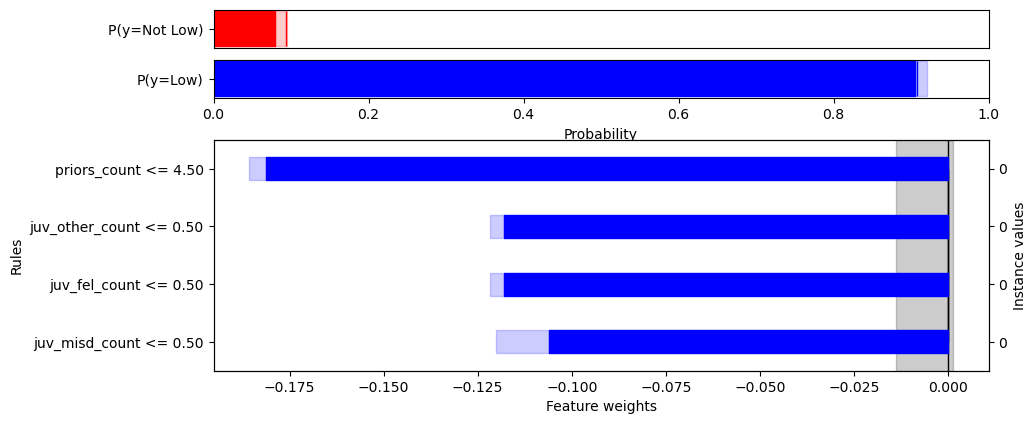

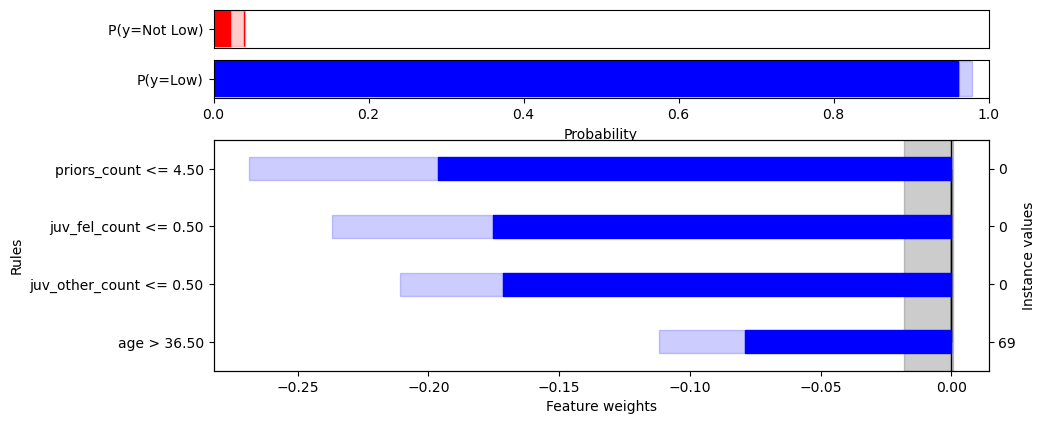

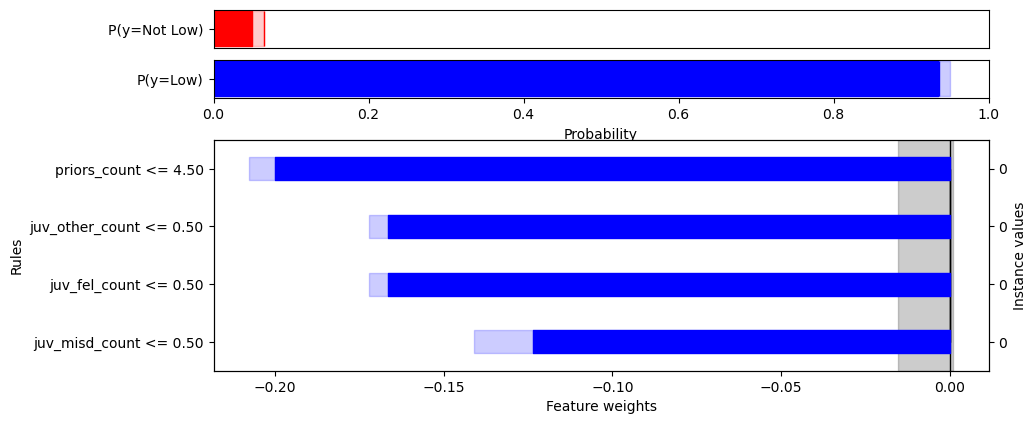

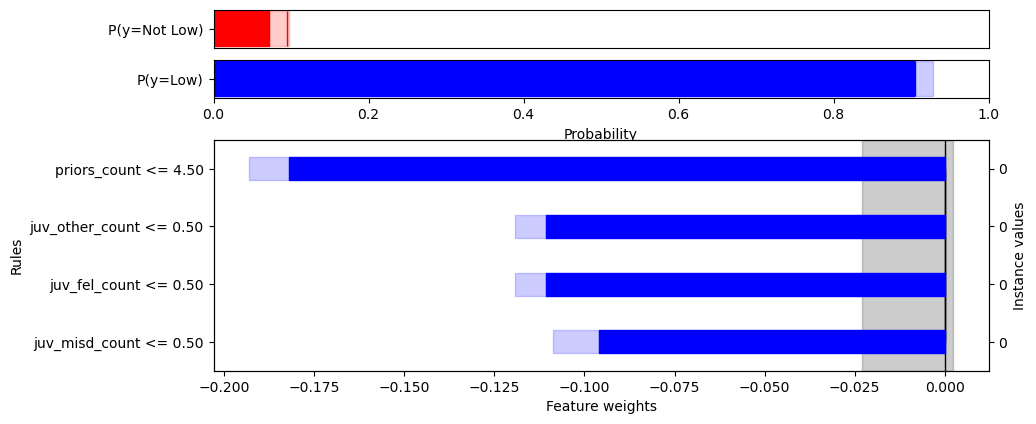

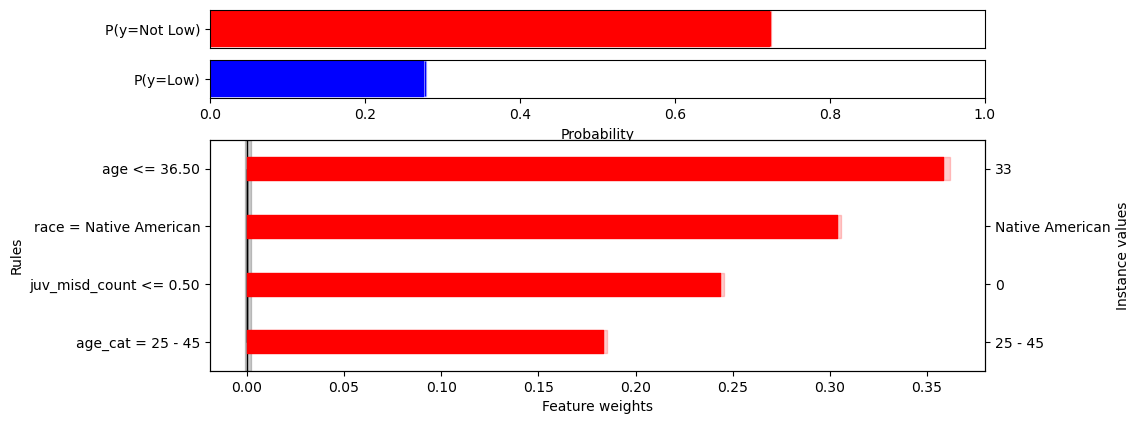

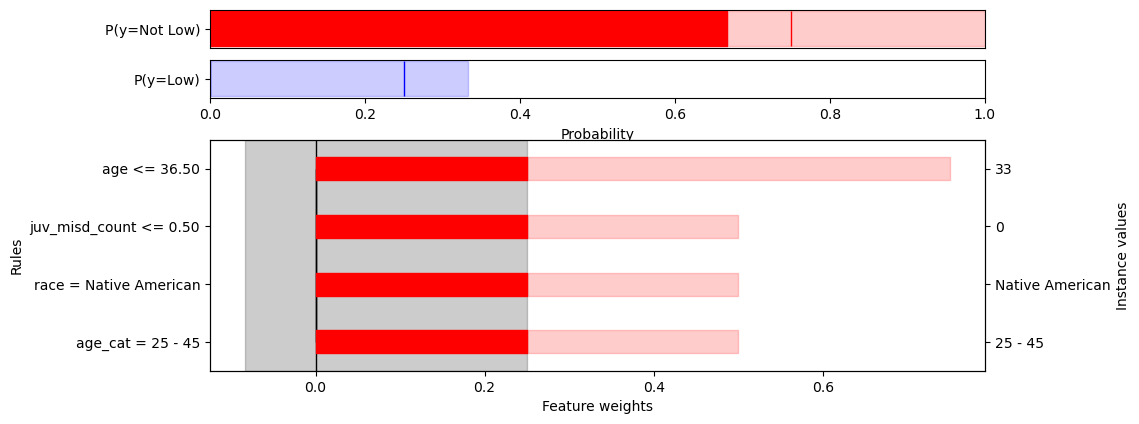

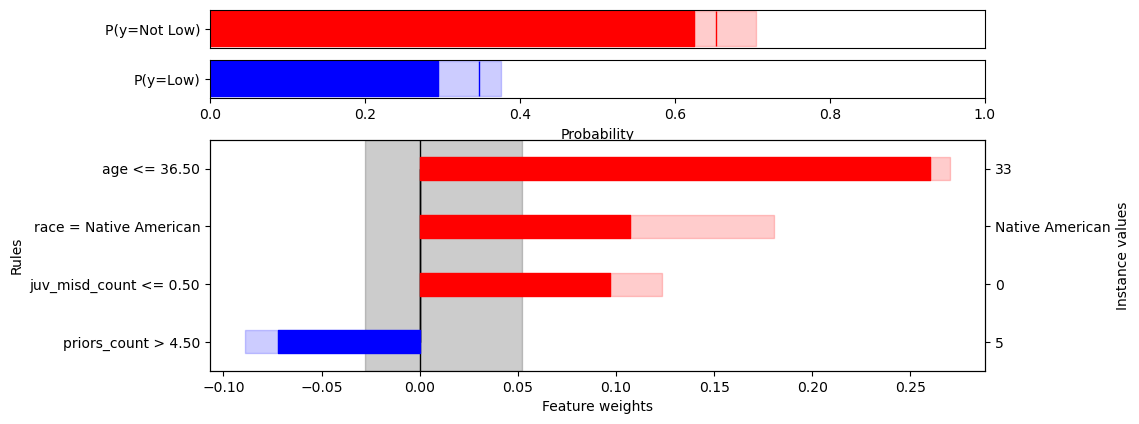

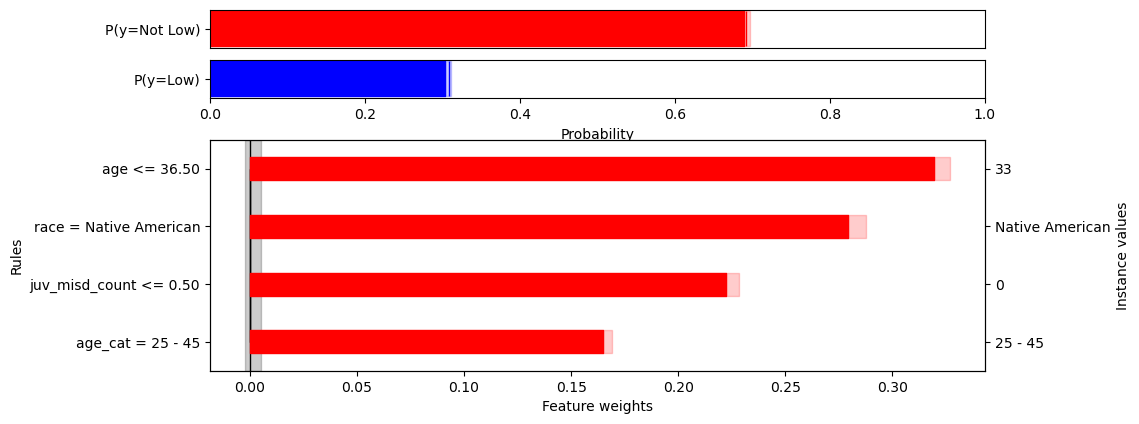

In [10]:
for i in range(len(testY)):     
    factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_race.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_sex.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_recid.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [11]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation_race = ce_race.explain_counterfactual(testX, bins=testX[:,race])
counterfactual_explanation_sex = ce_sex.explain_counterfactual(testX, bins=testX[:,sex])
counterfactual_explanation_recid = ce_recid.explain_counterfactual(testX, bins=df['is_recid'].values[test_index])

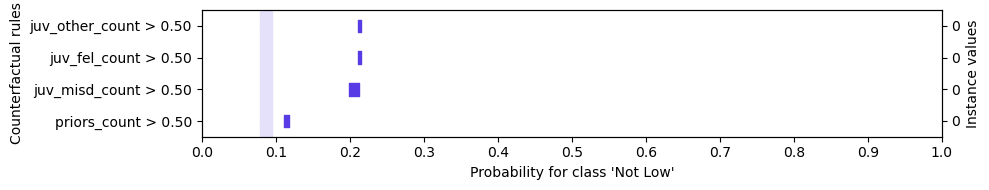

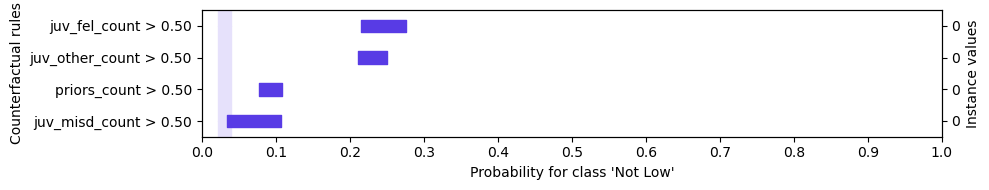

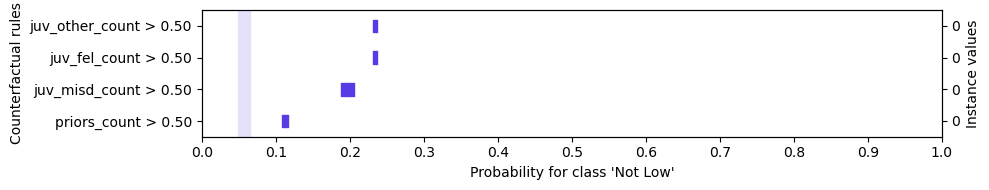

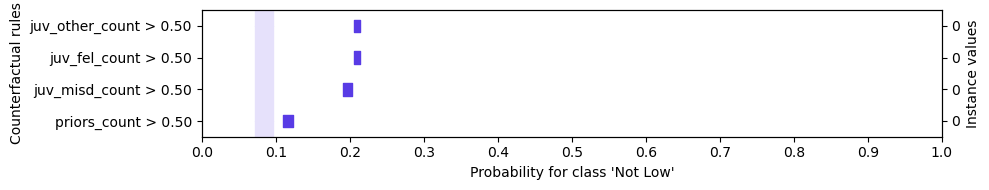

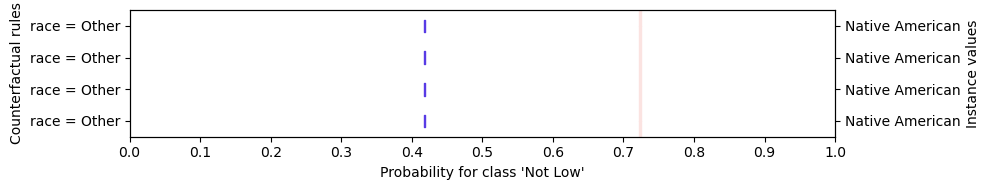

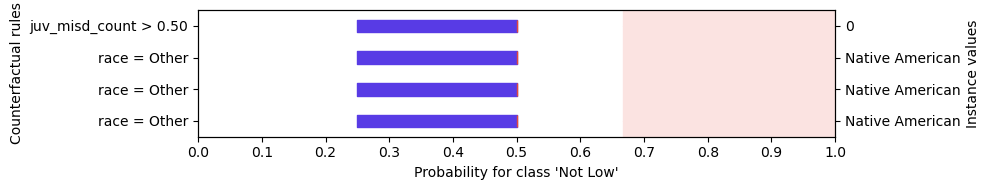

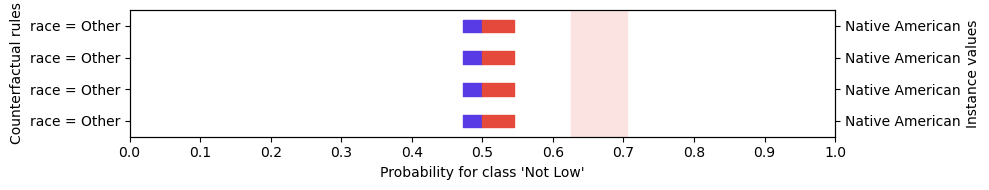

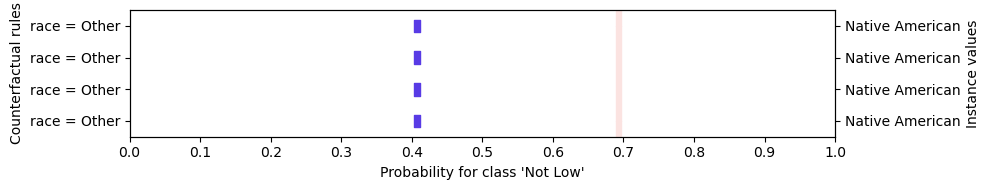

In [12]:
for i in range(len(testY)):     
    counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_race.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_sex.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_recid.plot_explanation(i, n_features_to_show=4)

# Adult

In [13]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAG

In [14]:
df = X
target = 'Income'
y = y.replace('<=50K.', '<=50K')
y = y.replace('>50K.', '>50K')
df[target] = y
df = df.dropna()
df, categorical_features, categorical_labels, target_labels, _ = transform_to_numeric(df, target)
print(target_labels)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\utils.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.replace("'", "")
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\utils.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.replace('"', '')
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\utils.py:216: SettingWithCopyWarning: 
A val

{0: '<=50K', 1: '>50K'}


c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\utils.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].map(mapping)
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\utils.py:191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.replace("'", "")
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\utils.py:192: SettingWithCopyWarning: 
A value is tr

In [15]:
num_to_test = 2 # number of instances to test, one from each class

Xd, yd = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(yd))
no_of_features = Xd.shape[1]
no_of_instances = Xd.shape[0]

# select test instances from each class and split into train, cal and test
idx = np.argsort(yd.values).astype(int)
X, y = Xd.values[idx,:], yd.values[idx]
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)

print(testY)
print(categorical_features)
print(*[f"{key}: {value}" for key, value in categorical_labels.items()], sep="\n")
print(target_labels)

[0 1]
[1, 3, 5, 6, 7, 8, 9, 13]
1: {0: 'State-gov', 1: 'Self-emp-not-inc', 2: 'Private', 3: 'Federal-gov', 4: 'Local-gov', 5: '?', 6: 'Self-emp-inc', 7: 'Without-pay', 8: 'Never-worked'}
3: {0: 'Bachelors', 1: 'HS-grad', 2: '11th', 3: 'Masters', 4: '9th', 5: 'Some-college', 6: 'Assoc-acdm', 7: 'Assoc-voc', 8: '7th-8th', 9: 'Doctorate', 10: 'Prof-school', 11: '5th-6th', 12: '10th', 13: '1st-4th', 14: 'Preschool', 15: '12th'}
5: {0: 'Never-married', 1: 'Married-civ-spouse', 2: 'Divorced', 3: 'Married-spouse-absent', 4: 'Separated', 5: 'Married-AF-spouse', 6: 'Widowed'}
6: {0: 'Adm-clerical', 1: 'Exec-managerial', 2: 'Handlers-cleaners', 3: 'Prof-specialty', 4: 'Other-service', 5: 'Sales', 6: 'Craft-repair', 7: 'Transport-moving', 8: 'Farming-fishing', 9: 'Machine-op-inspct', 10: 'Tech-support', 11: '?', 12: 'Protective-serv', 13: 'Armed-Forces', 14: 'Priv-house-serv'}
7: {0: 'Not-in-family', 1: 'Husband', 2: 'Wife', 3: 'Own-child', 4: 'Unmarried', 5: 'Other-relative'}
8: {0: 'White', 1: 

In [16]:
print(df.columns)
edu = 3
race = 8
sex = 9

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'Income'],
      dtype='object')


In [17]:
model = RandomForestClassifier()

model.fit(trainX,trainY)  

RandomForestClassifier()

In [18]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels)
ce_race = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,race]) 
ce_sex = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,sex]) 
ce_edu = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=df.columns,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,edu]) 
display(ce)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


CalibratedExplainer:
	                mode=classification
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                

In [19]:
factual_explanation = ce.explain_factual(testX)
factual_explanation_race = ce_race.explain_factual(testX, bins=testX[:,race])
factual_explanation_sex = ce_sex.explain_factual(testX, bins=testX[:,sex])
factual_explanation_edu = ce_edu.explain_factual(testX, bins=testX[:,edu])

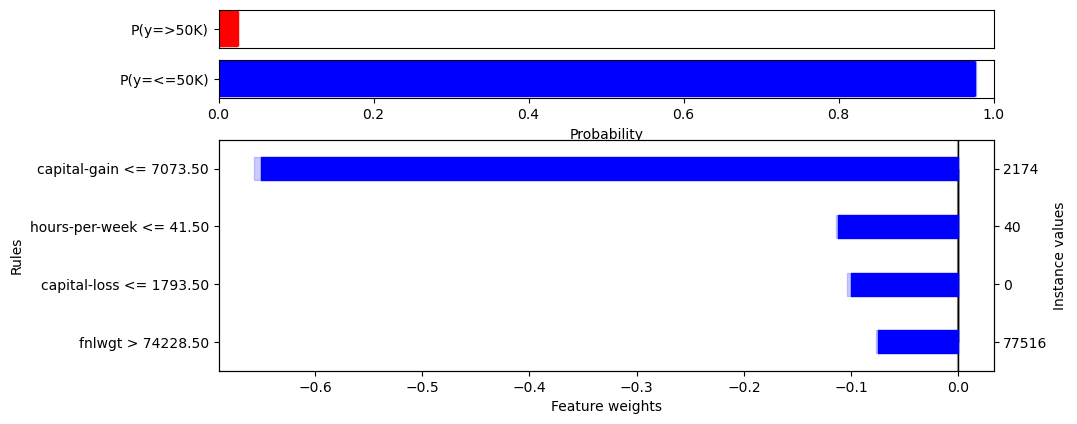

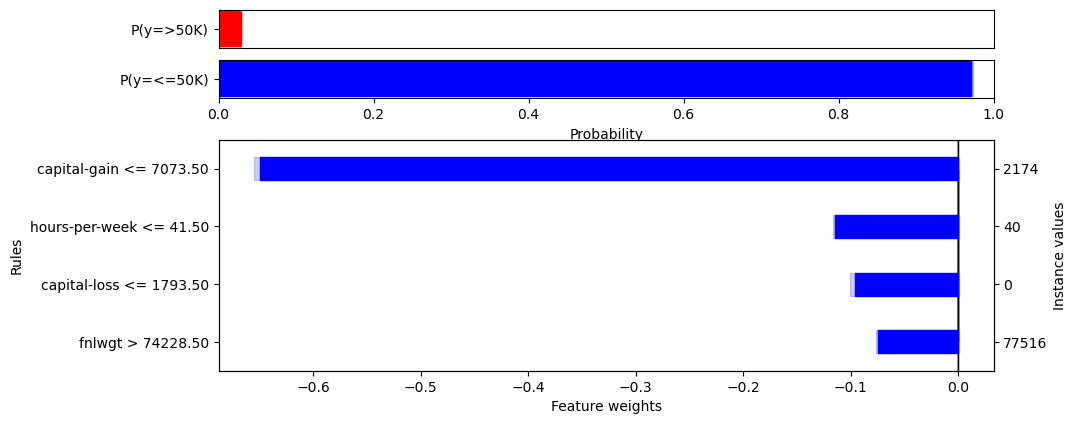

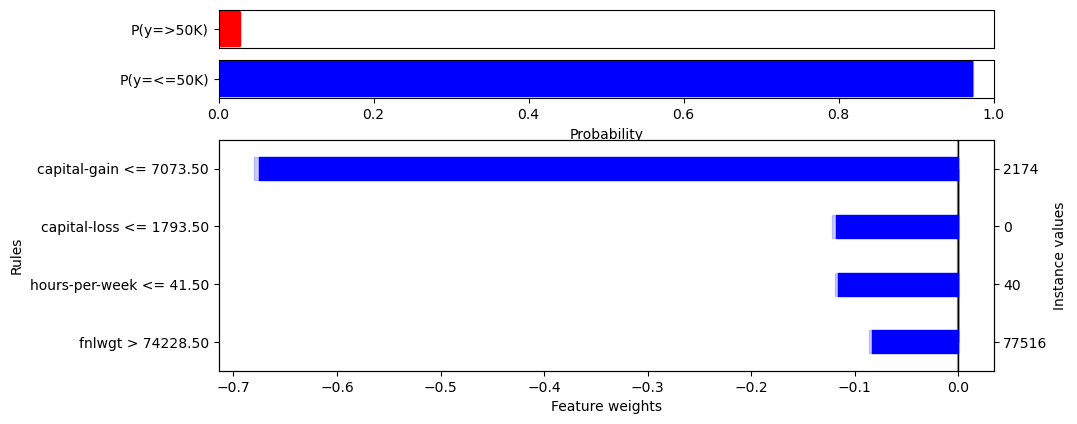

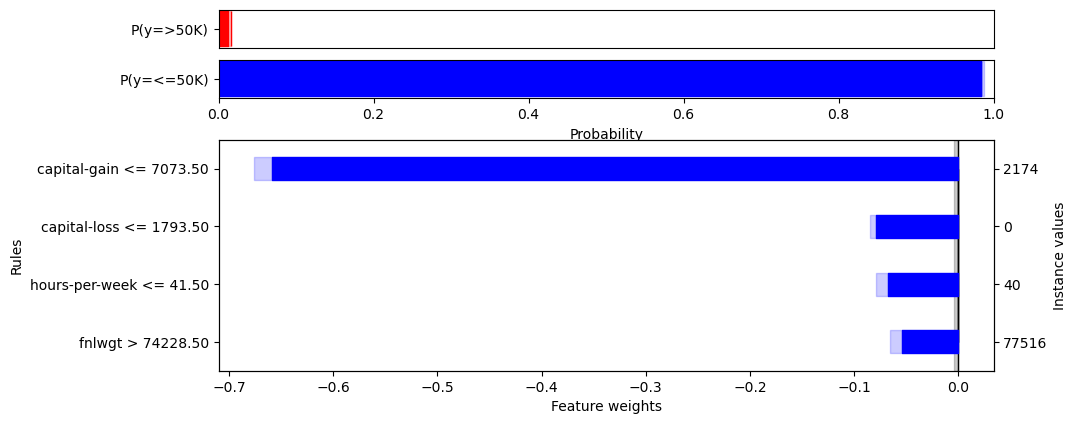

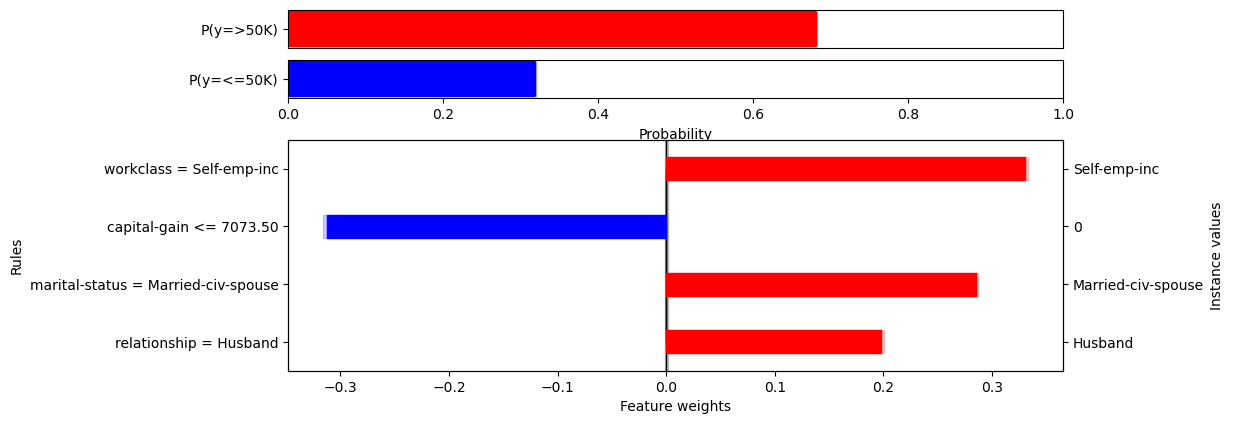

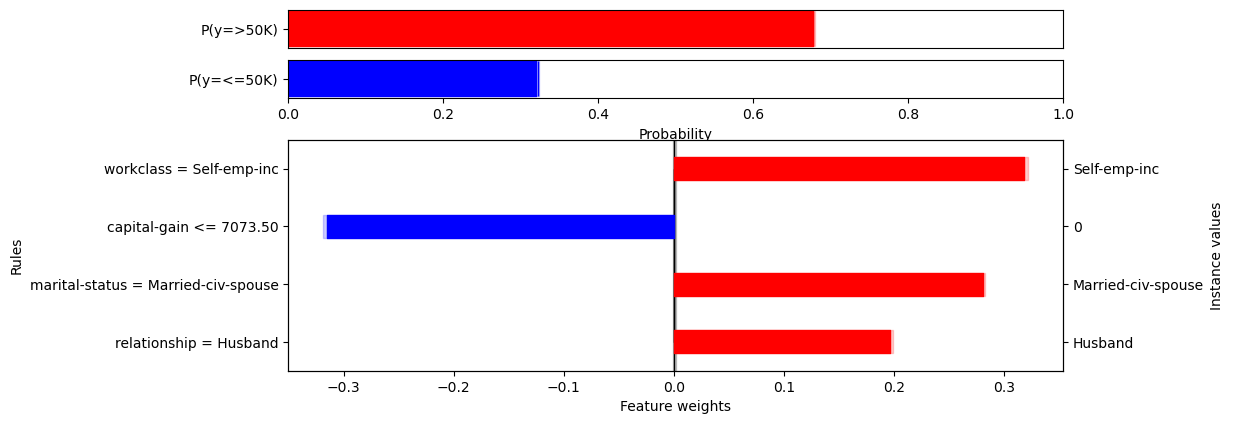

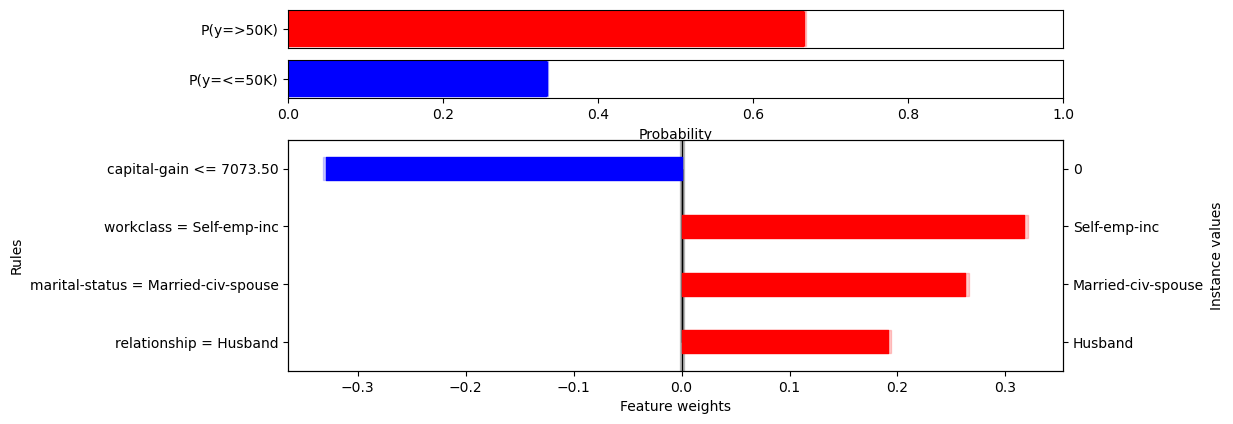

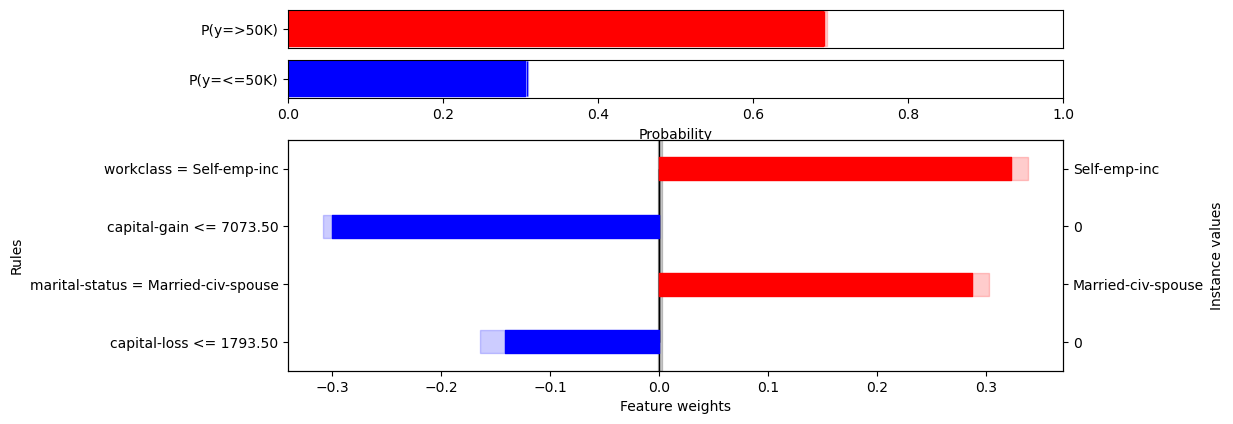

In [20]:
for i in range(len(testY)):     
    factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_race.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_sex.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_edu.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [21]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation_race = ce_race.explain_counterfactual(testX, bins=testX[:,race])
counterfactual_explanation_sex = ce_sex.explain_counterfactual(testX, bins=testX[:,sex])
counterfactual_explanation_edu = ce_edu.explain_counterfactual(testX, bins=testX[:,edu])

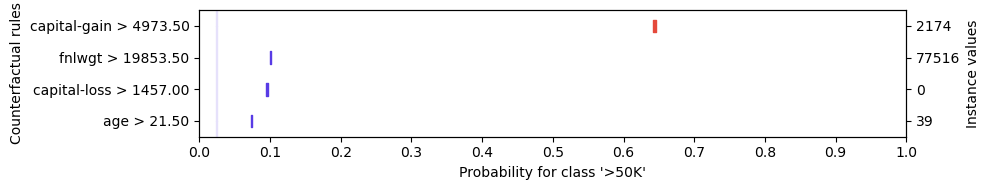

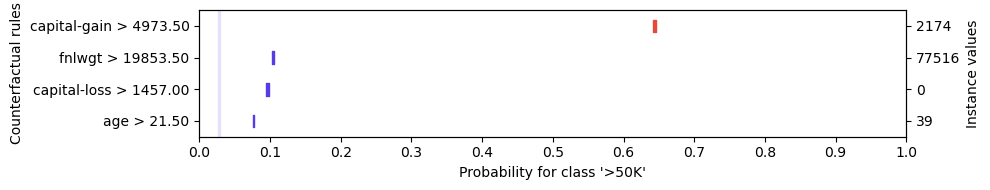

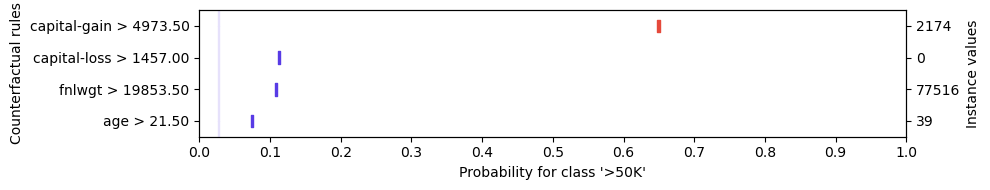

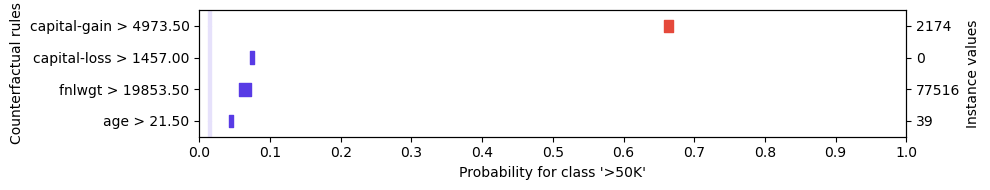

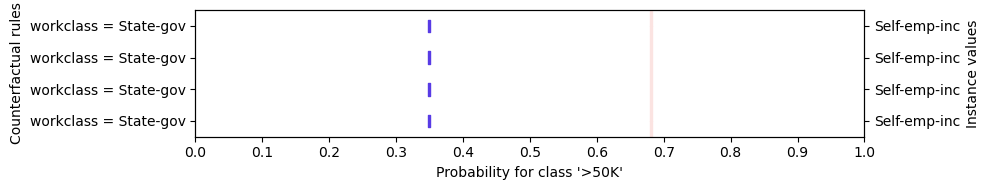

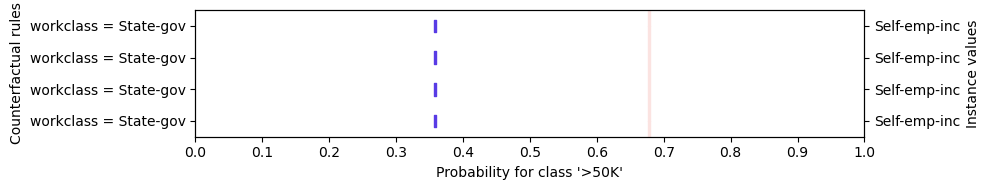

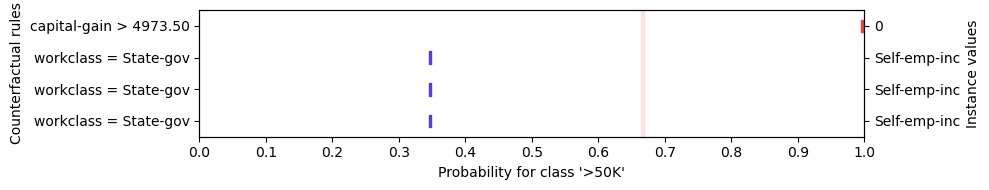

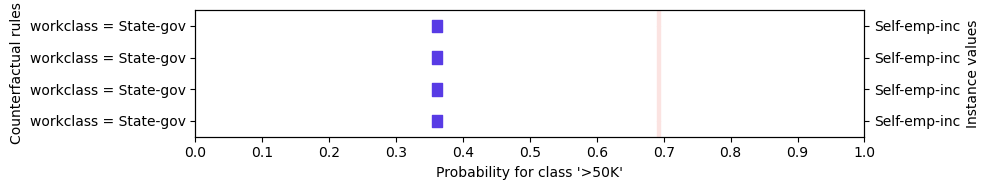

In [22]:
for i in range(len(testY)):     
    counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_race.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_sex.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_edu.plot_explanation(i, n_features_to_show=4)

# German


In [23]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

In [24]:
feature_names = statlog_german_credit_data.variables.description[:-1]
feature_names[0] = 'Status'
feature_names[7] = 'Installment rate'
feature_names[15] = 'Existing credits'
feature_names[17] = 'Num people liable'
target_labels = {1: 'Good', 0: 'Bad'}

In [25]:
print(feature_names)
age = 12
sex = 8

0                         Status
1                       Duration
2                 Credit history
3                        Purpose
4                  Credit amount
5          Savings account/bonds
6       Present employment since
7               Installment rate
8        Personal status and sex
9     Other debtors / guarantors
10       Present residence since
11                      Property
12                           Age
13       Other installment plans
14                       Housing
15              Existing credits
16                           Job
17             Num people liable
18                     Telephone
19                foreign worker
Name: description, dtype: object


In [26]:
df = X
target = 'Class'
df[target] = y
df = df.dropna()
df, categorical_features, categorical_labels, _, _ = transform_to_numeric(df, target)

In [27]:
num_to_test = 2 # number of instances to test, one from each class

Xd, yd = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(yd))
no_of_features = Xd.shape[1]
no_of_instances = Xd.shape[0]

# select test instances from each class and split into train, cal and test
idx = np.argsort(yd.values).astype(int)
X, y = Xd.values[idx,:], yd.values[idx]
y[y==2] = 0
test_index = np.array([*range(int(num_to_test/2)), *range(no_of_instances-1, no_of_instances-int(num_to_test/2)-1,-1)])
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)

print(testY)
print(categorical_features)
print(*[f"{key}: {value}" for key, value in categorical_labels.items()], sep="\n")
print(target_labels)

[1 0]
[0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
0: {0: 'A11', 1: 'A12', 2: 'A14', 3: 'A13'}
2: {0: 'A34', 1: 'A32', 2: 'A33', 3: 'A30', 4: 'A31'}
3: {0: 'A43', 1: 'A46', 2: 'A42', 3: 'A40', 4: 'A41', 5: 'A49', 6: 'A44', 7: 'A45', 8: 'A410', 9: 'A48'}
5: {0: 'A65', 1: 'A61', 2: 'A63', 3: 'A64', 4: 'A62'}
6: {0: 'A75', 1: 'A73', 2: 'A74', 3: 'A71', 4: 'A72'}
8: {0: 'A93', 1: 'A92', 2: 'A91', 3: 'A94'}
9: {0: 'A101', 1: 'A103', 2: 'A102'}
11: {0: 'A121', 1: 'A122', 2: 'A124', 3: 'A123'}
13: {0: 'A143', 1: 'A141', 2: 'A142'}
14: {0: 'A152', 1: 'A153', 2: 'A151'}
16: {0: 'A173', 1: 'A172', 2: 'A174', 3: 'A171'}
18: {0: 'A192', 1: 'A191'}
19: {0: 'A201', 1: 'A202'}
{1: 'Good', 0: 'Bad'}


In [28]:
model = RandomForestClassifier()

model.fit(trainX,trainY)  

RandomForestClassifier()

In [29]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels)
age_cal_bin, age_cal_boundaries = binning(calX[:,age], bins=5)
ce_age = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=age_cal_bin) 
ce_sex = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        class_labels=target_labels,
                        bins=calX[:,sex]) 
display(ce)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:
c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\venn_abers\venn_abers.py:102: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


CalibratedExplainer:
	                mode=classification
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                

In [30]:
factual_explanation = ce.explain_factual(testX)
age_test_bin = binning(testX[:,age], age_cal_boundaries)
factual_explanation_age = ce_age.explain_factual(testX, bins=age_test_bin)
factual_explanation_sex = ce_sex.explain_factual(testX, bins=testX[:,sex])

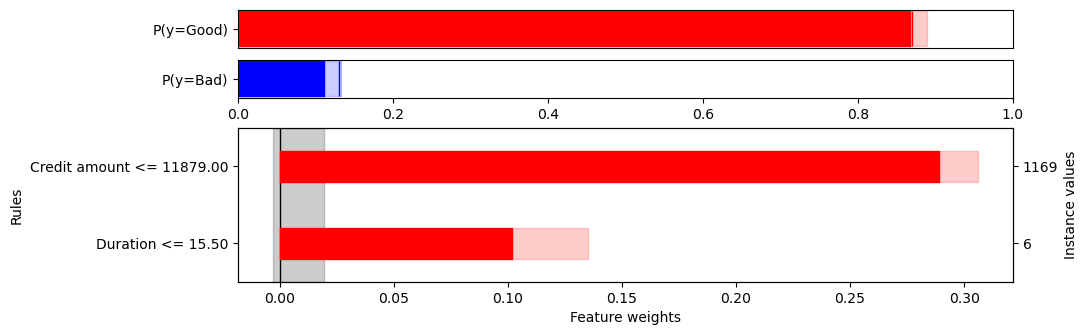

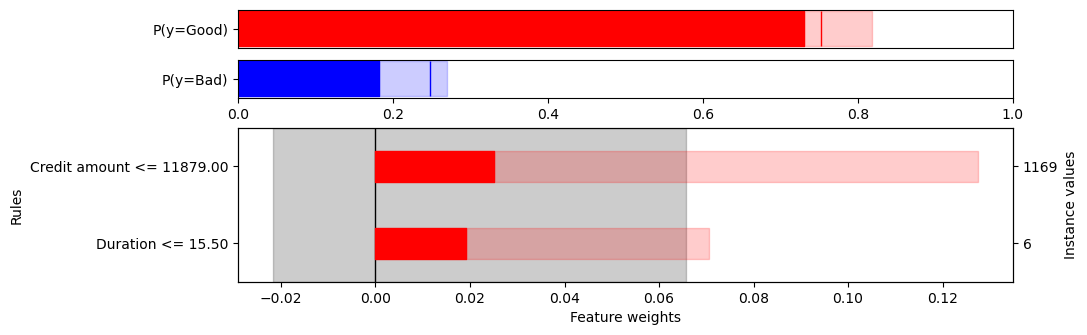

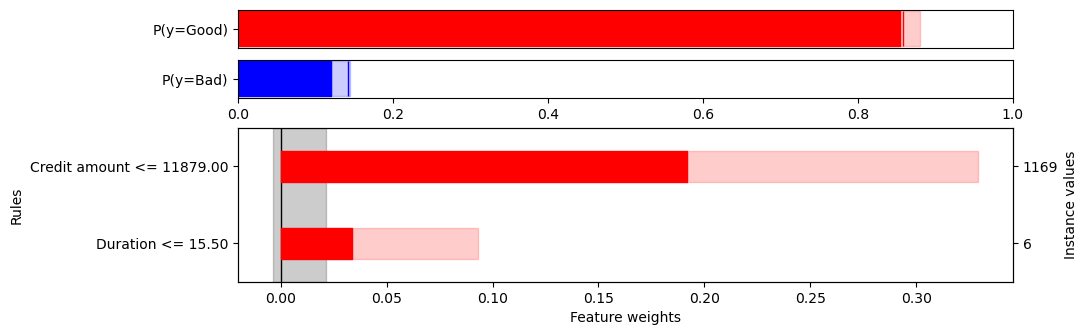

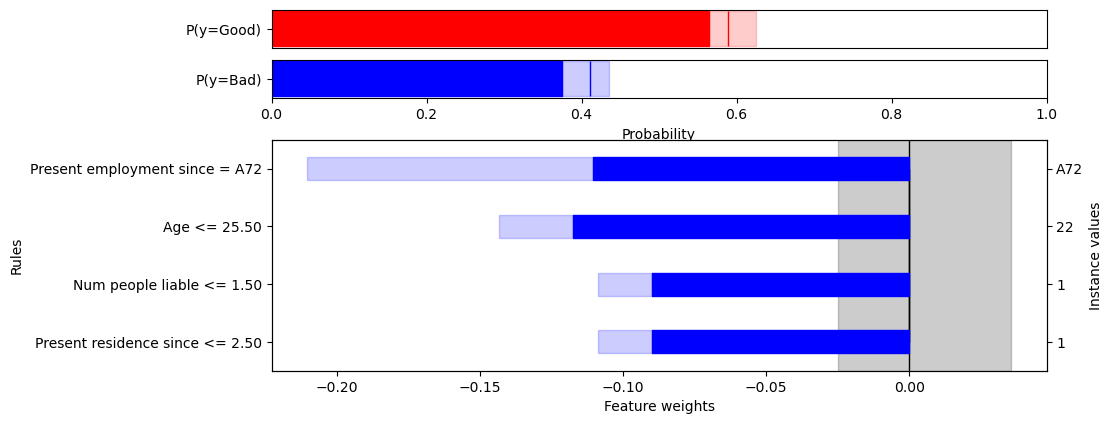

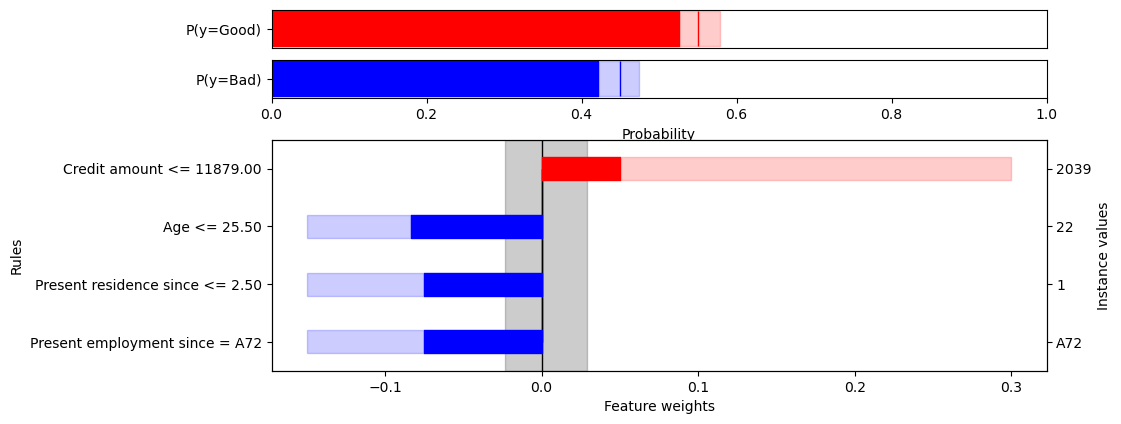

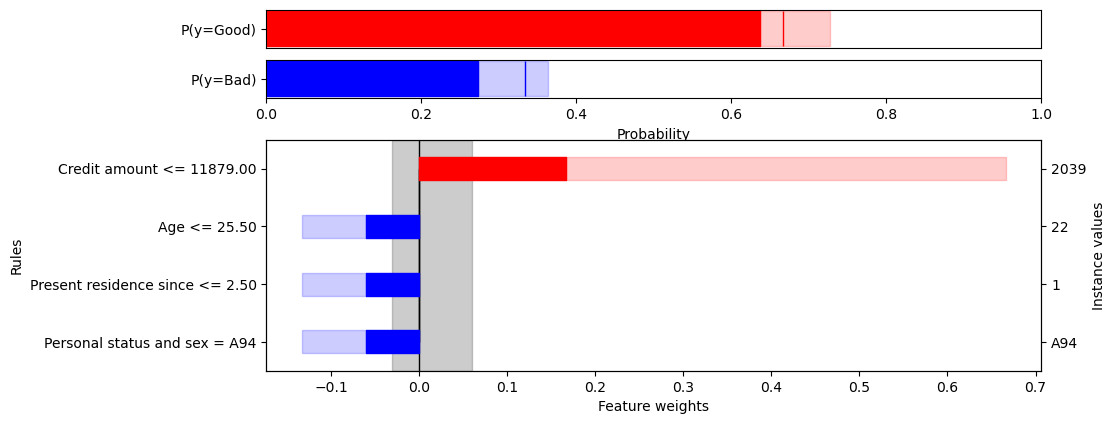

In [31]:
for i in range(len(testY)):     
    factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_age.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_sex.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [32]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation_age = ce_age.explain_counterfactual(testX, bins=age_test_bin)
counterfactual_explanation_sex = ce_sex.explain_counterfactual(testX, bins=testX[:,sex])

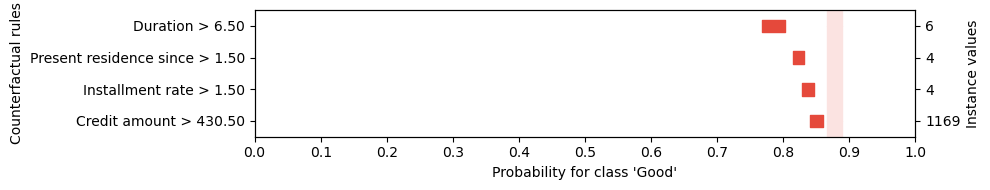

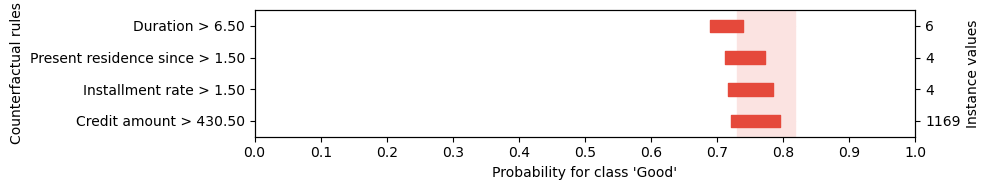

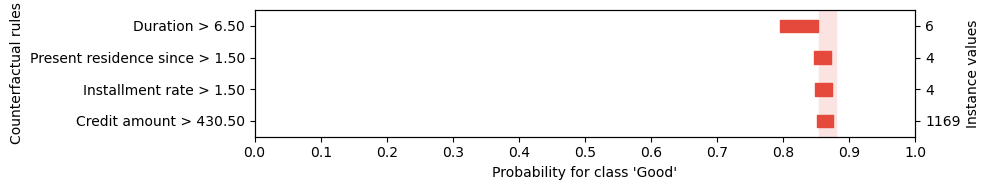

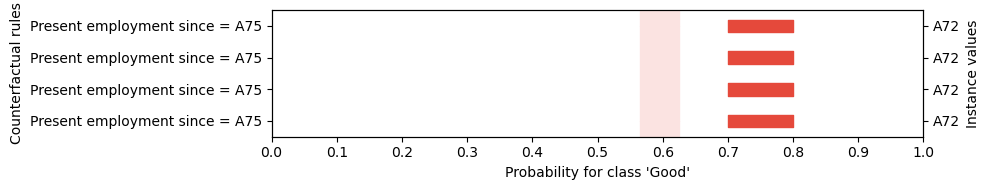

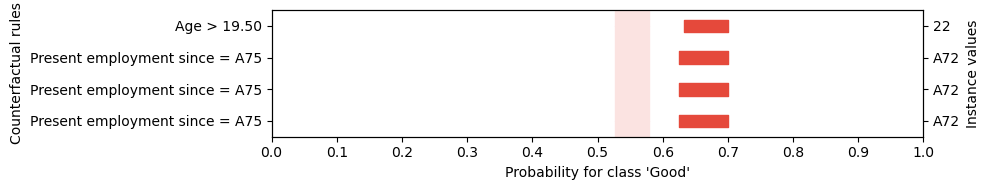

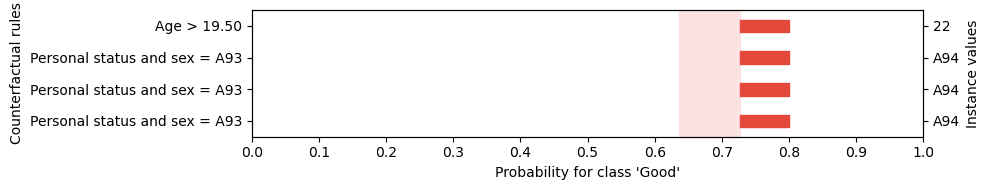

In [33]:
for i in range(len(testY)):     
    counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_age.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_sex.plot_explanation(i, n_features_to_show=4)

# Boston

In [3]:
df = pd.read_csv('../data/reg/HousingData.csv', na_values='NA')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [4]:
feature_names = df.columns[:-1]
print(feature_names)
crm = 0

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


In [5]:
target = 'MEDV'
df = df.dropna()
df, categorical_features, categorical_labels, target_labels, _ = transform_to_numeric(df, target)

In [6]:
num_to_test = 2 # number of instances to test, one from each class

Xd, yd = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(yd))
no_of_features = Xd.shape[1]
no_of_instances = Xd.shape[0]

trainCalX, testX, trainCalY, testY = train_test_split(Xd.values, yd.values, test_size=num_to_test,random_state=42)
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42)

print(testY)

[25.  18.6]


In [7]:
model = RandomForestRegressor()

model.fit(trainX,trainY)  

RandomForestRegressor()

In [8]:
ce = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        mode='regression',
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels)
crm_cal_bins, crm_cal_boundaries = binning(calX[:,crm], bins=3)
ce_crm = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        mode='regression',
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        bins=crm_cal_bins) 
display(ce)

CalibratedExplainer:
	                mode=regression
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestRegressor()
	                difficulty_estimator=None

### Standard Regression
Default confidence of 90%

In [9]:
factual_explanation = ce.explain_factual(testX)
crm_test_bins = binning(testX[:,crm], crm_cal_boundaries)
factual_explanation_crm = ce_crm.explain_factual(testX, bins=crm_test_bins)

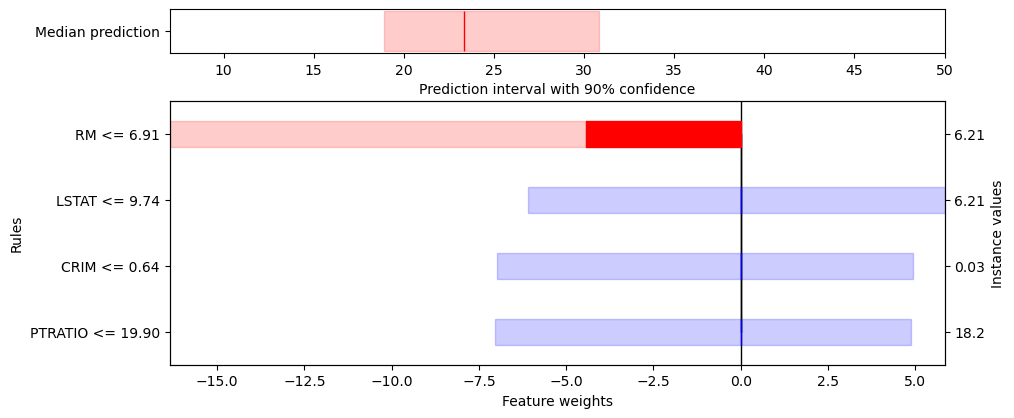

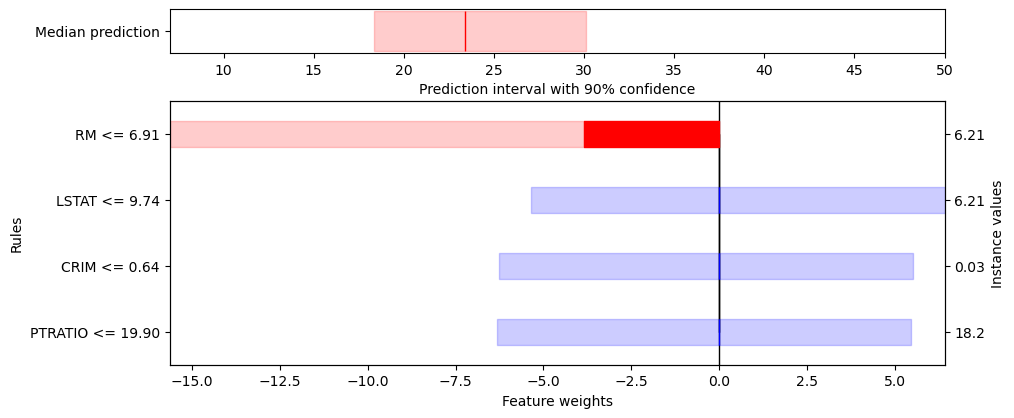

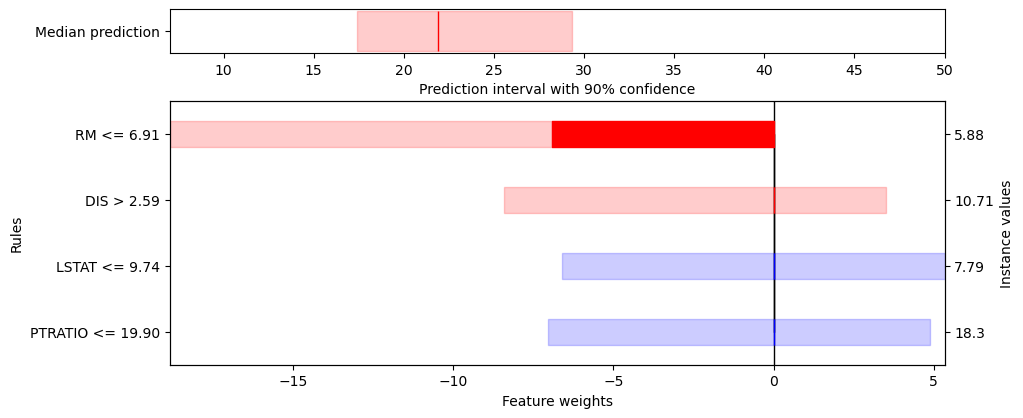

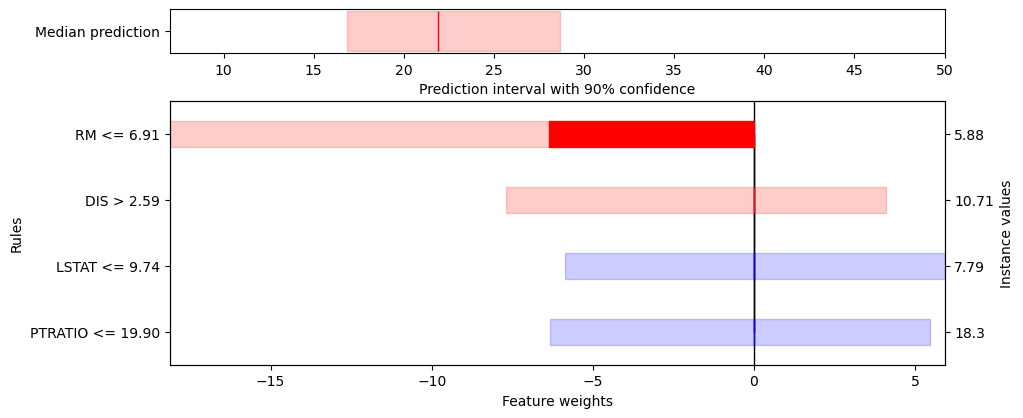

In [10]:
for i in range(len(testY)):     
    factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_crm.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [11]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation_crm = ce_crm.explain_counterfactual(testX, bins=crm_test_bins)

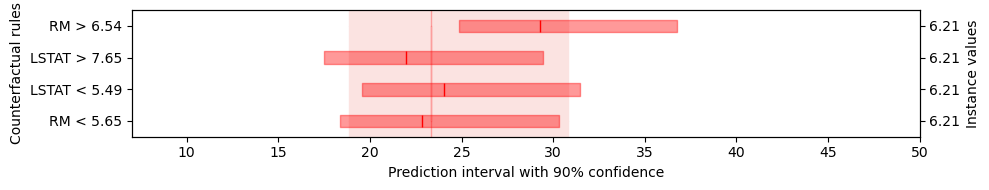

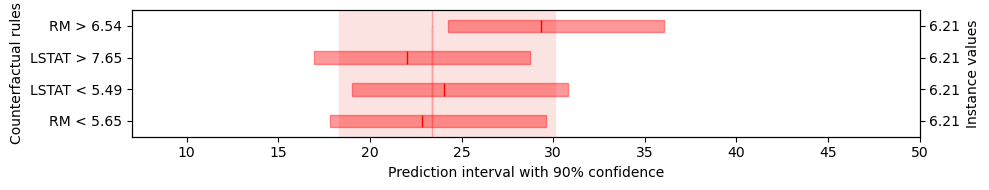

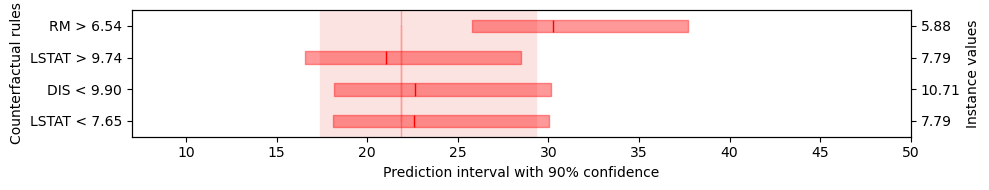

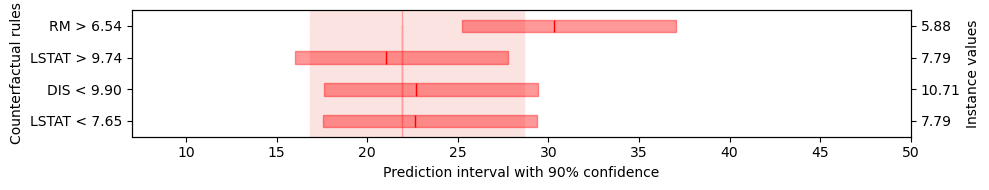

In [12]:
for i in range(len(testY)):     
    counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_crm.plot_explanation(i, n_features_to_show=4)

In [32]:
prob_factual_explanation = ce.explain_factual(testX, threshold=20)
prob_factual_explanation_crm = ce_crm.explain_factual(testX, threshold=20, bins=crm_test_bins)

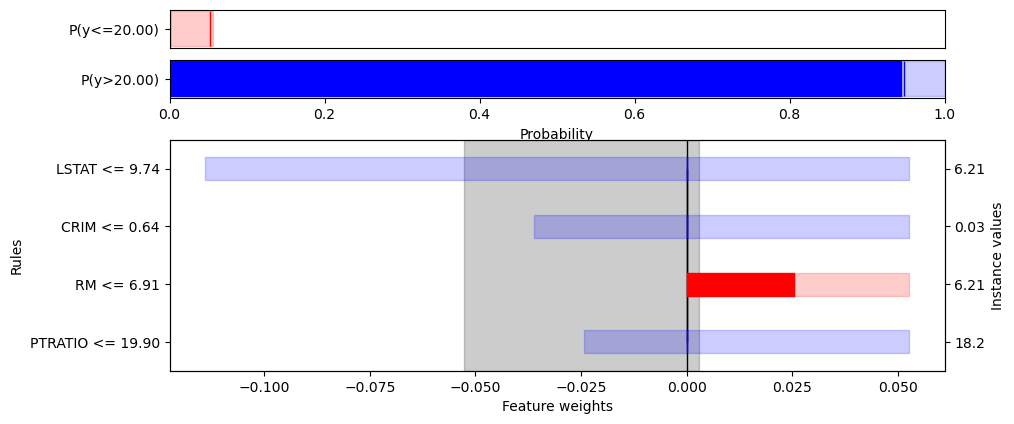

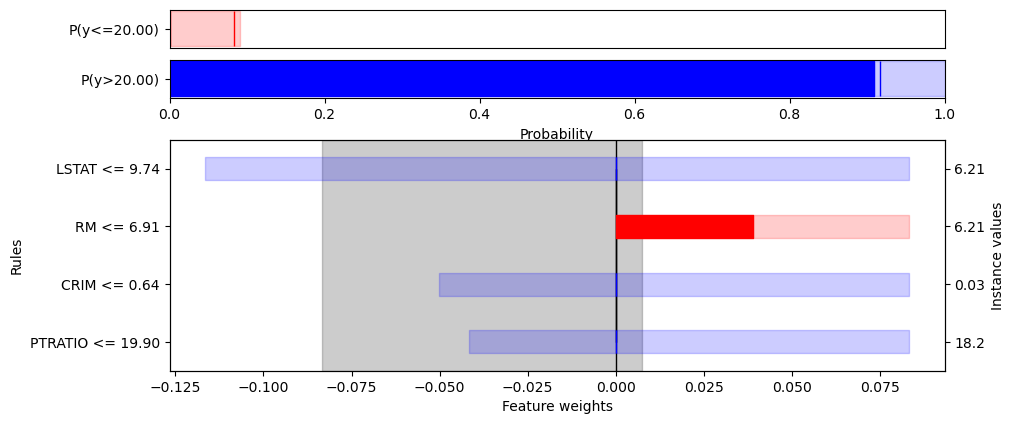

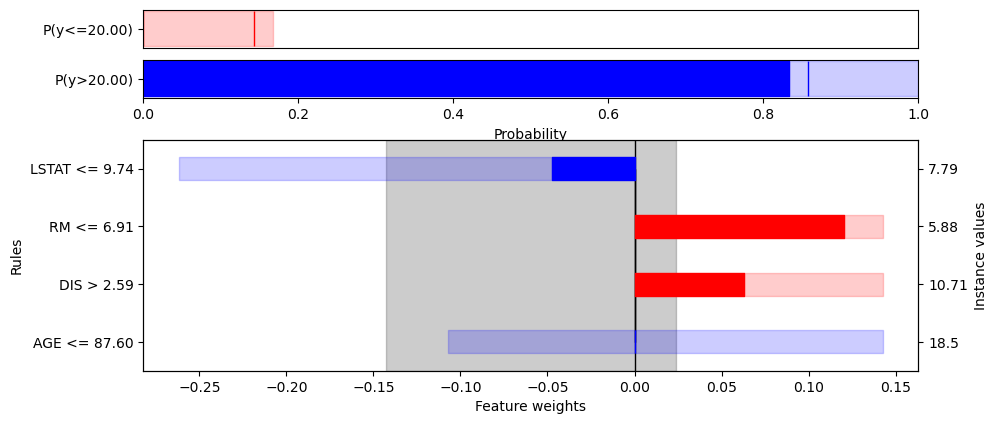

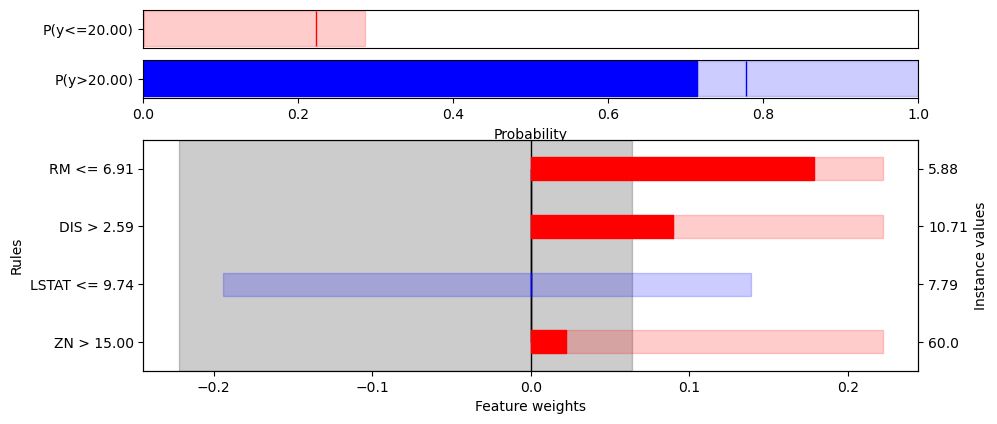

In [33]:
for i in range(len(testY)):     
    prob_factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    prob_factual_explanation_crm.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [30]:
prob_counterfactual_explanation = ce.explain_counterfactual(testX, threshold=20)
prob_counterfactual_explanation_crm = ce_crm.explain_counterfactual(testX, threshold=20, bins=crm_test_bins)

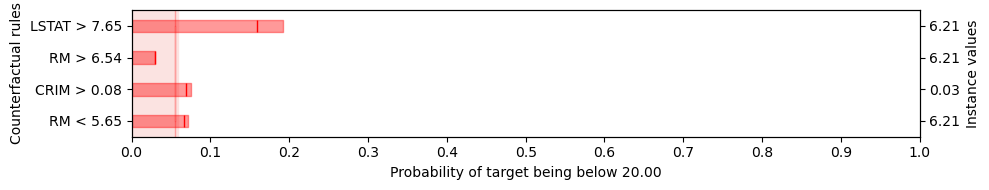

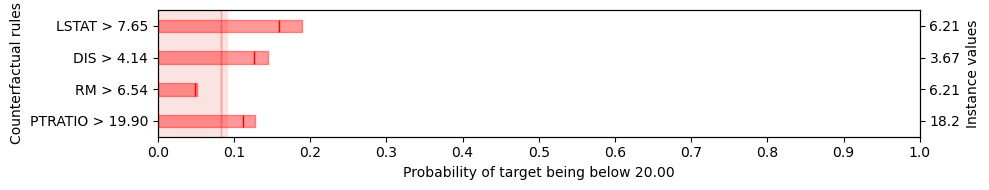

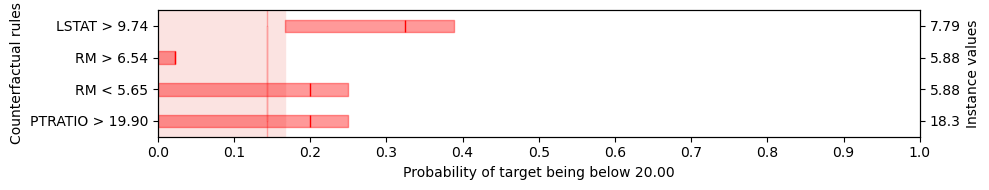

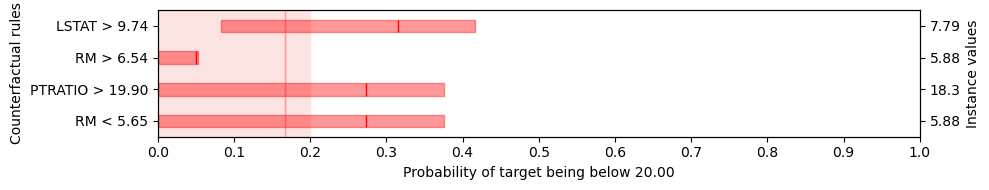

In [31]:
for i in range(len(testY)):     
    prob_counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    prob_counterfactual_explanation_crm.plot_explanation(i, n_features_to_show=4)

## Normalized Explanations

In [ ]:
difficulty = DifficultyEstimator().fit(X=trainX, learner=model, scaler=True)

ce = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        mode='regression',
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        difficulty_estimator=difficulty)
crm_cal_bins, crm_cal_boundaries = binning(calX[:,crm], bins=6)
ce_crm = CalibratedExplainer(model, 
                        calX, 
                        calY,
                        mode='regression',
                        feature_names=feature_names,                    
                        categorical_features=categorical_features, 
                        categorical_labels=categorical_labels,
                        difficulty_estimator=difficulty,
                        bins=crm_cal_bins) 
display(ce)

CalibratedExplainer:
	                mode=regression
	                mondrian=False
	                discretizer=<class 'NoneType'>
	                model=RandomForestRegressor()
	                difficulty_estimator=DifficultyEstimator(fitted=True, type=variance, scaler=True, beta=0.01, oob=False)

In [ ]:
factual_explanation = ce.explain_factual(testX)
crm_test_bins = binning(testX[:,crm], crm_cal_boundaries)
factual_explanation_crm = ce_crm.explain_factual(testX, bins=crm_test_bins)

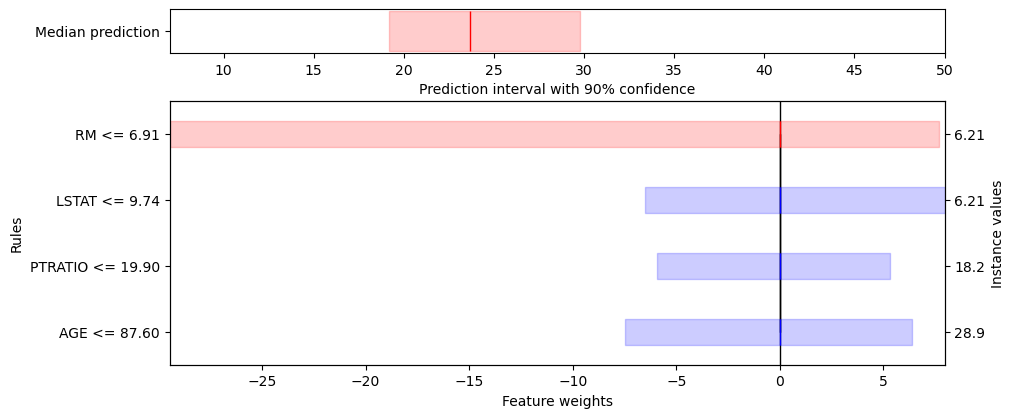

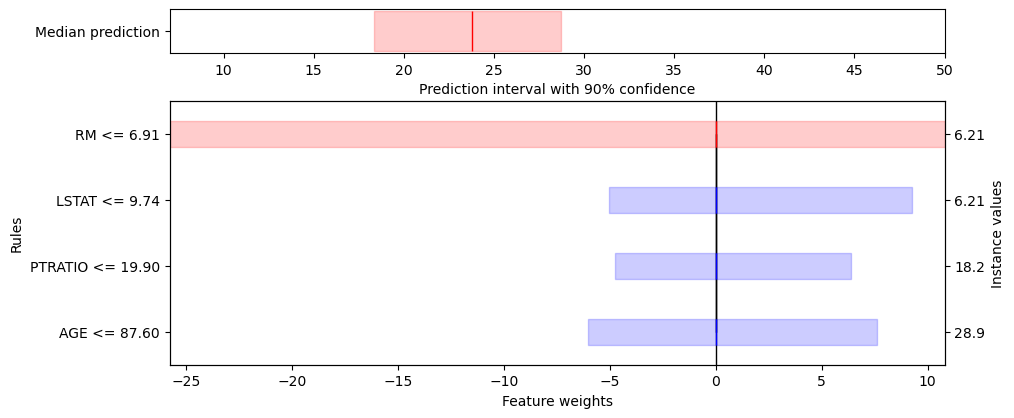

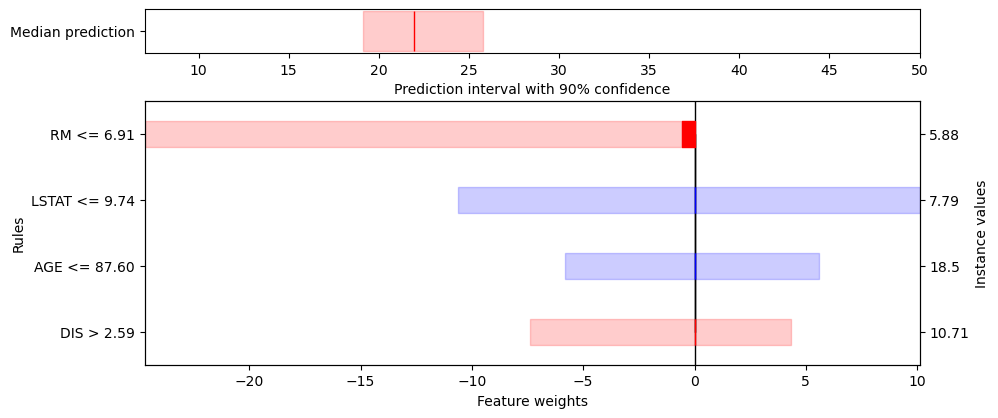

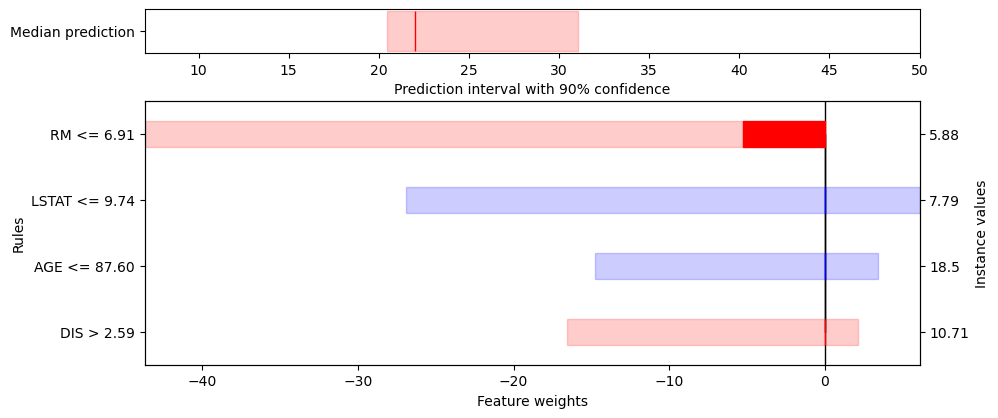

In [ ]:
for i in range(len(testY)):     
    factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    factual_explanation_crm.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [ ]:
counterfactual_explanation = ce.explain_counterfactual(testX)
counterfactual_explanation_crm = ce_crm.explain_counterfactual(testX, bins=crm_test_bins)

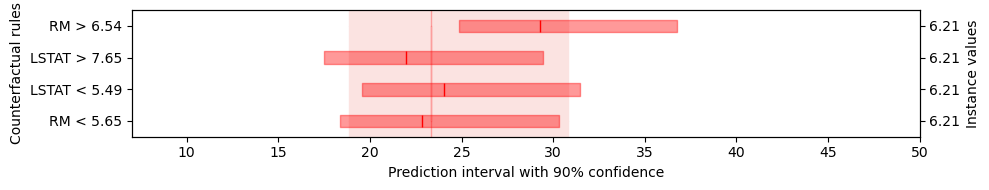

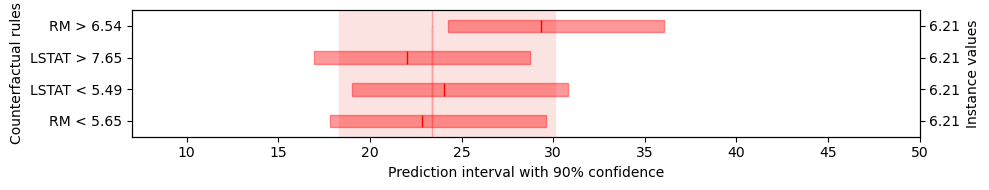

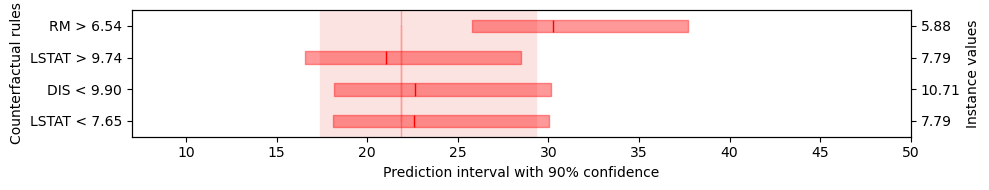

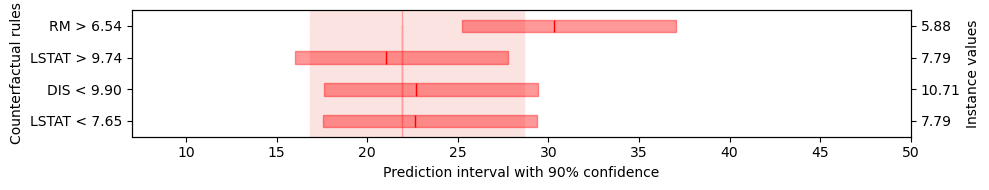

In [23]:
for i in range(len(testY)):     
    counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    counterfactual_explanation_crm.plot_explanation(i, n_features_to_show=4)

In [26]:
prob_factual_explanation = ce.explain_factual(testX, threshold=20)
prob_factual_explanation_crm = ce_crm.explain_factual(testX, threshold=20, bins=crm_test_bins)

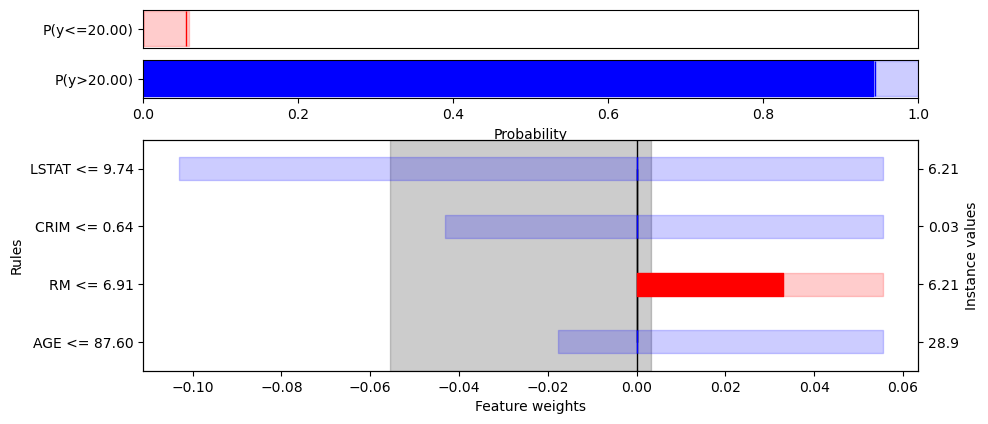

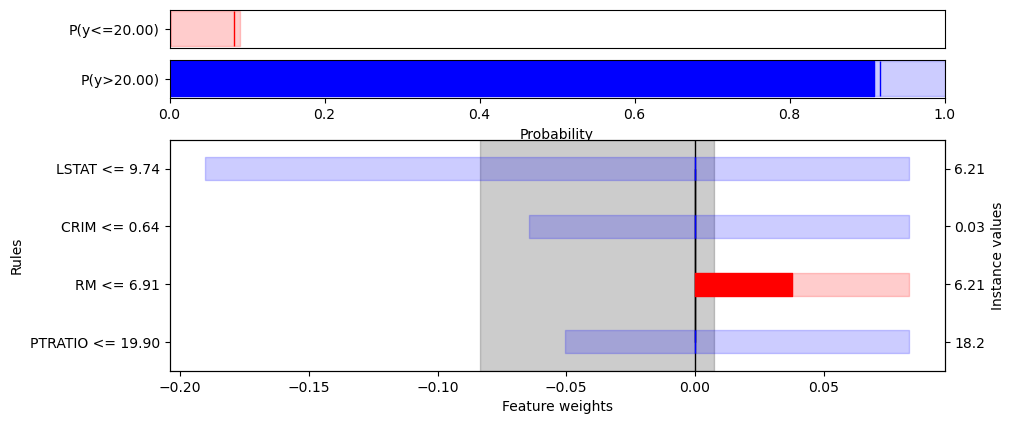

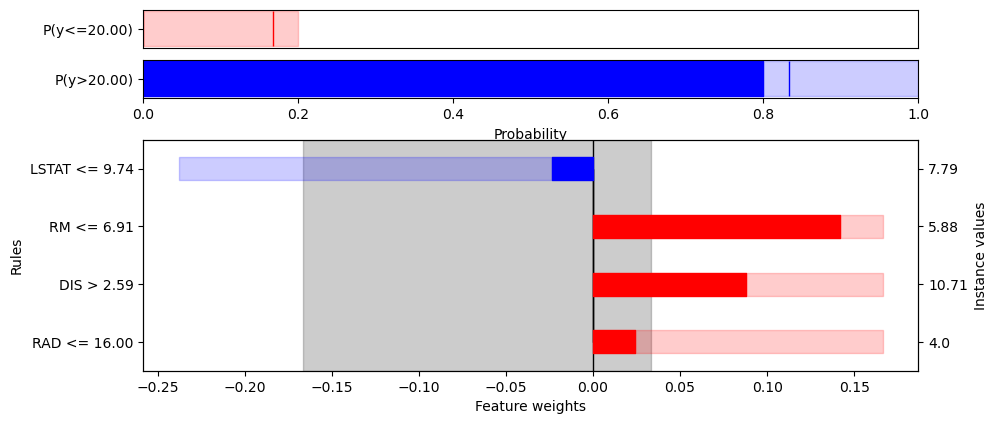

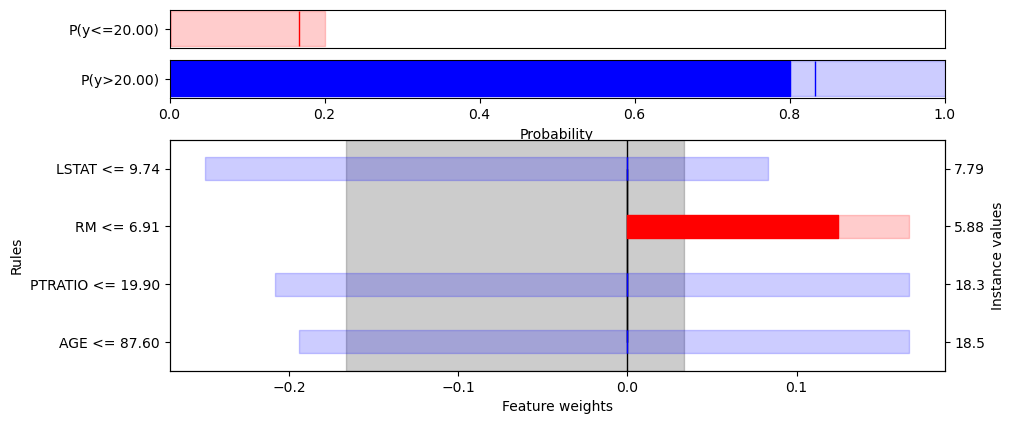

In [27]:
for i in range(len(testY)):     
    prob_factual_explanation.plot_explanation(i, n_features_to_show=4, uncertainty=True)
    prob_factual_explanation_crm.plot_explanation(i, n_features_to_show=4, uncertainty=True)

In [28]:
prob_counterfactual_explanation = ce.explain_counterfactual(testX, threshold=20)
prob_counterfactual_explanation_crm = ce_crm.explain_counterfactual(testX, threshold=20, bins=crm_test_bins)

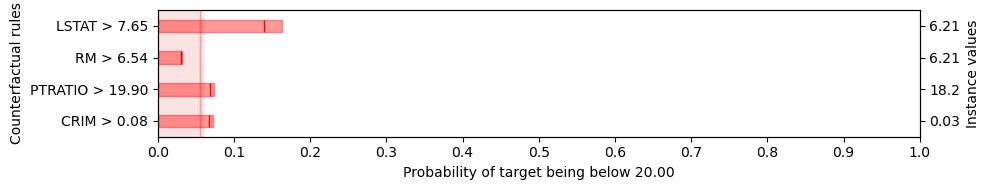

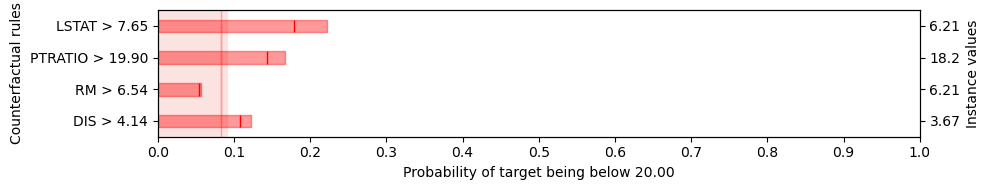

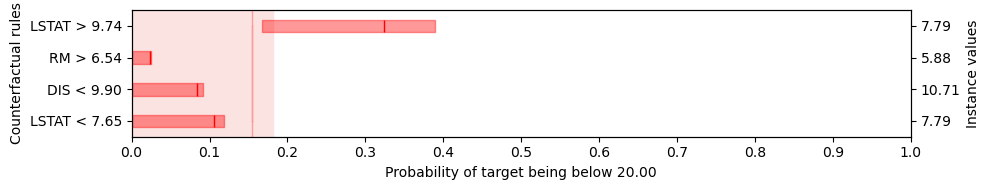

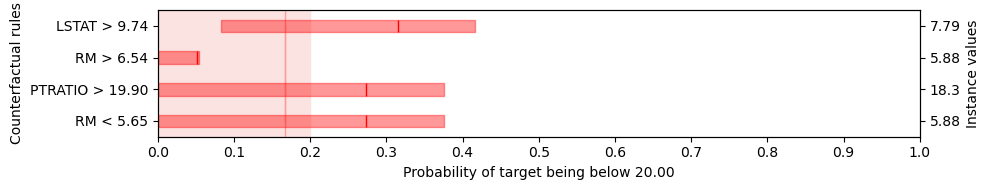

In [29]:
for i in range(len(testY)):     
    prob_counterfactual_explanation.plot_explanation(i, n_features_to_show=4)
    prob_counterfactual_explanation_crm.plot_explanation(i, n_features_to_show=4)